In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# 이미지 전처리: 텐서로 변환하고 픽셀 값을 [-1, 1]로 정규화
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# MNIST 데이터셋 로드 (자동 다운로드)
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)

# DataLoader 정의
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 485kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.43MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.9MB/s]


In [2]:
import imageio  # 이미지 데이터를 읽고 쓸 수 있는 쉬운 인터페이스 제공하는 라이브러리
from tqdm import tqdm

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
import matplotlib.pylab as plt
import matplotlib

from torchvision.utils import make_grid, save_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms
matplotlib.style.use('ggplot')  # stylesheet 변경하여 사용 - 'ggplot' : 격자무늬 백그라운드 삽입
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# 변수 값 설정
batch_size = 512
epochs = 200
sample_size = 64  # 노이즈 벡터 사용하여 가짜 이미지 생성
nz = 128  # 잠재 벡터 크기
k = 1 # 판별자에 적용할 스텝 수

In [4]:
# 생성자 네트워크 생성
class Generator(nn.Module):
    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)
        # 생성자 네트워크의 반환값은 '배치 크기x1x28x28'이 됨.

In [5]:
# 판별자 네트워크 생성
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784  # 판별자의 입력 크기
        self.main = nn.Sequential(
            # 판별자 역시 선형 계층과 리키렐루 활성화 함수로 구성
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)   # 이미지가 진짜인지 가짜인지 분류하는 값 반환

In [6]:
# 생성자와 판별자 네크워크 초기화
# 생성자는 잠재 벡터 nz라는 변수를 파라미터로 전달해야 함.
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print(generator)
print(discriminator)

Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1, bias=True)
    (10): Sigmoid()
  )
)


In [7]:
# 옵티마이저와 손실 함수 정의
optim_g = optim.Adam(generator.parameters(), lr = 0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr = 0.0002)

criterion = nn.BCELoss()

losses_g = []  # 매 에포크마다 발생하는 생성자 오차 저장하기 위한 리스트형 변수
losses_d = []  # 매 에포크마다 발생하는 판별자 오차 저장하기 위한 리스트형 변수
images = []  # 생성자에 의해 생성되는 이미지 저장하기 위한 리스트형 변수

In [8]:
# 생성된 이미지 저장 함수 정의
# 이미지가 생성되는 과정을 이해할 수 있도록 시각화하여 보여 줌.
def save_generator_image(image, path):
    save_image(image, path)

In [9]:
# 판별자 학습을 위한 함수
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)  # 배치 크기 정보 얻기
    real_label = torch.ones(b_size, 1).to(device)
    fake_label = torch.zeros(b_size, 1).to(device)
    optimizer.zero_grad()
    output_real = discriminator(data_real)
    loss_real = criterion(output_real, real_label)
    # 진짜 데이터를 판별자에 제공하여 학습한 결과와 진짜 데이터의 레이블 이용하여 오차 계산
    output_fake = discriminator(data_fake)
    loss_fake = criterion(output_fake, fake_label)
    # 가짜 데이터를 판별자에 제공하여 학습한 결과와 가짜 데이터의 레이블 이용하여 오차 계산
    loss_real.backward()
    loss_fake.backward()
    optimizer.step()
    return loss_real + loss_fake
    # 진짜 데이터와 가짜 데이터의 오차 합쳐진 최종 오차 반환

In [10]:
# 생성자 학습을 위한 함수
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = torch.ones(b_size, 1).to(device)
    optimizer.zero_grad()
    output = discriminator(data_fake)
    loss = criterion(output, real_label)
    loss.backward()
    optimizer.step()
    return loss

In [11]:
!mkdir img #img 폴더 만들기

In [12]:
# 모델 학습
generator.train()  # 생성자를 학습 모드로 설정
discriminator.train()  # 판별자를 학습 모드로 설정

for epoch in range(epochs):
    loss_g = 0.0  # 생성자 오차를 추적(저장)하기 위한 변수
    loss_d = 0.0  # 판별자 오차를 추적(저장)하기 위한 변수
    for idx, data in tqdm(enumerate(train_loader),
                          total=int(len(train_dataset)/train_loader.batch_size)):
        image, _ = data  # 학습을 위한 이미지 데이터 가져옴.
        image = image.to(device)  # 데이터셋이 CPU/GPU 장치 사용하도록 지정
        b_size = len(image)
        for step in range(k):
        # k(1) 스텝 수에 따라 판별자 실행, 이때 k 수를 증가시킬 수 있지만 학습 시간 길어질 수 있음.
            data_fake = generator(torch.randn(b_size, nz).to(device)).detach()
            data_real = image
            loss_d += train_discriminator(optim_d, data_real, data_fake)
        data_fake = generator(torch.randn(b_size, nz).to(device))
        loss_g += train_generator(optim_g, data_fake)  # 생성자 학습
    generated_img = generator(torch.randn(b_size, nz).to(device)).cpu().detach()
    # 생성자 이용하여 새로운 이미지 생성하고 CPU 장치 이용하여 디스크에 저장
    generated_img = make_grid(generated_img)  # 이미지를 그리드 형태로 표현
    save_generator_image(generated_img, "./img/gen_img{epoch}.png")
    # 생성된 이미지(텐서) 디스크에 저장
    images.append(generated_img)
    epoch_loss_g = loss_g / idx  # 에포크에 대한 총 생성자 오차 계산
    epoch_loss_d = loss_d / idx    # 에포크에 대한 총 판별자 오차 계산
    losses_g.append(loss_g)
    losses_d.append(loss_d)

    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

469it [00:24, 18.88it/s]                         


Epoch 0 of 200
Generator loss: 2.59330487, Discriminator loss: 0.97748244


469it [00:16, 28.20it/s]                         


Epoch 1 of 200
Generator loss: 2.95747423, Discriminator loss: 0.93208599


469it [00:15, 29.60it/s]


Epoch 2 of 200
Generator loss: 1.67881358, Discriminator loss: 1.00572133


469it [00:15, 30.54it/s]                         


Epoch 3 of 200
Generator loss: 2.24015284, Discriminator loss: 0.76586360


469it [00:17, 27.22it/s]                         


Epoch 4 of 200
Generator loss: 2.79672718, Discriminator loss: 0.53699821


469it [00:15, 30.31it/s]                         


Epoch 5 of 200
Generator loss: 3.30800629, Discriminator loss: 0.41168737


469it [00:15, 30.44it/s]                         


Epoch 6 of 200
Generator loss: 3.10661292, Discriminator loss: 0.48980346


469it [00:15, 29.40it/s]


Epoch 7 of 200
Generator loss: 2.90254164, Discriminator loss: 0.53441215


469it [00:15, 29.85it/s]                         


Epoch 8 of 200
Generator loss: 2.69738507, Discriminator loss: 0.54042184


469it [00:15, 31.25it/s]                         


Epoch 9 of 200
Generator loss: 2.46395063, Discriminator loss: 0.61827260


469it [00:15, 31.05it/s]


Epoch 10 of 200
Generator loss: 2.72770166, Discriminator loss: 0.52091271


469it [00:15, 29.78it/s]                         


Epoch 11 of 200
Generator loss: 2.55560613, Discriminator loss: 0.58671135


469it [00:15, 30.85it/s]


Epoch 12 of 200
Generator loss: 2.37906241, Discriminator loss: 0.67362082


469it [00:15, 30.98it/s]


Epoch 13 of 200
Generator loss: 2.21083856, Discriminator loss: 0.68274736


469it [00:14, 31.76it/s]


Epoch 14 of 200
Generator loss: 2.29445148, Discriminator loss: 0.68775481


469it [00:15, 30.36it/s]                         


Epoch 15 of 200
Generator loss: 2.33032298, Discriminator loss: 0.65514749


469it [00:14, 32.18it/s]


Epoch 16 of 200
Generator loss: 2.47252965, Discriminator loss: 0.64803690


469it [00:14, 32.17it/s]


Epoch 17 of 200
Generator loss: 2.14785862, Discriminator loss: 0.72754776


469it [00:14, 32.23it/s]                         


Epoch 18 of 200
Generator loss: 2.08080888, Discriminator loss: 0.76774287


469it [00:14, 31.82it/s]                         


Epoch 19 of 200
Generator loss: 2.07470489, Discriminator loss: 0.72547811


469it [00:15, 30.49it/s]                         


Epoch 20 of 200
Generator loss: 1.92943978, Discriminator loss: 0.77886969


469it [00:14, 31.89it/s]


Epoch 21 of 200
Generator loss: 2.00707197, Discriminator loss: 0.77609462


469it [00:14, 31.84it/s]


Epoch 22 of 200
Generator loss: 1.86092293, Discriminator loss: 0.80902970


469it [00:15, 31.13it/s]                         


Epoch 23 of 200
Generator loss: 1.82520330, Discriminator loss: 0.83352125


469it [00:15, 30.15it/s]                         


Epoch 24 of 200
Generator loss: 1.75534093, Discriminator loss: 0.85431564


469it [00:14, 31.65it/s]


Epoch 25 of 200
Generator loss: 1.78358316, Discriminator loss: 0.85637426


469it [00:14, 31.90it/s]                         


Epoch 26 of 200
Generator loss: 1.70979345, Discriminator loss: 0.86090410


469it [00:14, 31.34it/s]


Epoch 27 of 200
Generator loss: 1.72547603, Discriminator loss: 0.88215768


469it [00:15, 30.34it/s]                         


Epoch 28 of 200
Generator loss: 1.72175765, Discriminator loss: 0.87370247


469it [00:15, 31.22it/s]


Epoch 29 of 200
Generator loss: 1.65592051, Discriminator loss: 0.89549780


469it [00:14, 31.82it/s]                         


Epoch 30 of 200
Generator loss: 1.54974854, Discriminator loss: 0.92445642


469it [00:14, 31.64it/s]                         


Epoch 31 of 200
Generator loss: 1.50453162, Discriminator loss: 0.96207011


469it [00:15, 30.55it/s]


Epoch 32 of 200
Generator loss: 1.54458559, Discriminator loss: 0.95678568


469it [00:14, 32.03it/s]                         


Epoch 33 of 200
Generator loss: 1.51132298, Discriminator loss: 0.95725083


469it [00:14, 31.59it/s]                         


Epoch 34 of 200
Generator loss: 1.53412604, Discriminator loss: 0.95704854


469it [00:14, 31.42it/s]                         


Epoch 35 of 200
Generator loss: 1.49374282, Discriminator loss: 0.96543360


469it [00:15, 30.19it/s]                         


Epoch 36 of 200
Generator loss: 1.46894860, Discriminator loss: 0.97263438


469it [00:14, 31.63it/s]                         


Epoch 37 of 200
Generator loss: 1.36139643, Discriminator loss: 1.02691412


469it [00:14, 31.71it/s]


Epoch 38 of 200
Generator loss: 1.33985269, Discriminator loss: 1.03934324


469it [00:14, 31.94it/s]


Epoch 39 of 200
Generator loss: 1.36570549, Discriminator loss: 1.03226674


469it [00:14, 31.48it/s]                         


Epoch 40 of 200
Generator loss: 1.37327731, Discriminator loss: 1.02498007


469it [00:14, 31.96it/s]                         


Epoch 41 of 200
Generator loss: 1.33631670, Discriminator loss: 1.04213428


469it [00:14, 32.40it/s]                         


Epoch 42 of 200
Generator loss: 1.31164253, Discriminator loss: 1.05223835


469it [00:14, 31.80it/s]


Epoch 43 of 200
Generator loss: 1.35238540, Discriminator loss: 1.03958797


469it [00:14, 32.03it/s]                         


Epoch 44 of 200
Generator loss: 1.32505143, Discriminator loss: 1.04237735


469it [00:15, 30.04it/s]                         


Epoch 45 of 200
Generator loss: 1.28646863, Discriminator loss: 1.05547190


469it [00:15, 30.89it/s]                         


Epoch 46 of 200
Generator loss: 1.29155064, Discriminator loss: 1.06809056


469it [00:15, 31.15it/s]                         


Epoch 47 of 200
Generator loss: 1.24987853, Discriminator loss: 1.07614636


469it [00:15, 31.21it/s]


Epoch 48 of 200
Generator loss: 1.23784137, Discriminator loss: 1.09441471


469it [00:15, 30.31it/s]                         


Epoch 49 of 200
Generator loss: 1.25755787, Discriminator loss: 1.08056939


469it [00:15, 31.09it/s]


Epoch 50 of 200
Generator loss: 1.19896889, Discriminator loss: 1.09485269


469it [00:14, 31.37it/s]


Epoch 51 of 200
Generator loss: 1.20303786, Discriminator loss: 1.11493456


469it [00:15, 31.13it/s]                         


Epoch 52 of 200
Generator loss: 1.18665588, Discriminator loss: 1.12401617


469it [00:15, 30.17it/s]                         


Epoch 53 of 200
Generator loss: 1.19428313, Discriminator loss: 1.10553694


469it [00:14, 31.37it/s]                         


Epoch 54 of 200
Generator loss: 1.19893837, Discriminator loss: 1.11504757


469it [00:15, 31.04it/s]                         


Epoch 55 of 200
Generator loss: 1.17726076, Discriminator loss: 1.11887872


469it [00:15, 30.30it/s]                         


Epoch 56 of 200
Generator loss: 1.15051675, Discriminator loss: 1.13334131


469it [00:15, 30.44it/s]                         


Epoch 57 of 200
Generator loss: 1.16775334, Discriminator loss: 1.12922609


469it [00:15, 30.97it/s]                         


Epoch 58 of 200
Generator loss: 1.14657545, Discriminator loss: 1.13391232


469it [00:14, 31.51it/s]                         


Epoch 59 of 200
Generator loss: 1.14542091, Discriminator loss: 1.14162970


469it [00:15, 30.32it/s]                         


Epoch 60 of 200
Generator loss: 1.12730014, Discriminator loss: 1.14205062


469it [00:15, 29.88it/s]                         


Epoch 61 of 200
Generator loss: 1.11651373, Discriminator loss: 1.14162469


469it [00:15, 31.08it/s]


Epoch 62 of 200
Generator loss: 1.10934234, Discriminator loss: 1.15730643


469it [00:15, 31.26it/s]                         


Epoch 63 of 200
Generator loss: 1.09658396, Discriminator loss: 1.16510844


469it [00:15, 29.46it/s]                         


Epoch 64 of 200
Generator loss: 1.08935654, Discriminator loss: 1.16804326


469it [00:15, 30.72it/s]                         


Epoch 65 of 200
Generator loss: 1.08742714, Discriminator loss: 1.17986465


469it [00:15, 31.15it/s]


Epoch 66 of 200
Generator loss: 1.09695840, Discriminator loss: 1.15834248


  4%|▍         | 20/468 [00:00<00:14, 31.28it/s]


KeyboardInterrupt: 

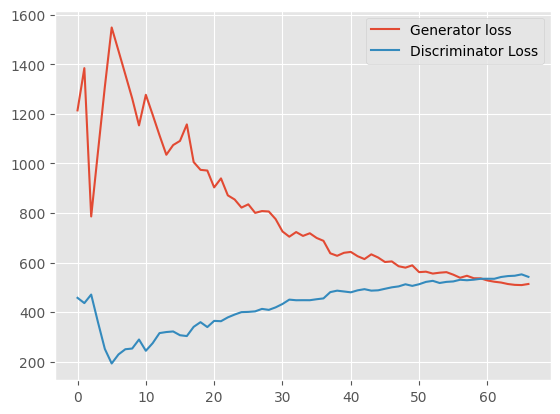

In [13]:
# 생성자와 판별자의 오차 확인
plt.figure()
losses_g = [f1.item() for f1 in losses_g]
plt.plot(losses_g, label='Generator loss')
losses_d = [f2.item() for f2 in losses_d]
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.show()

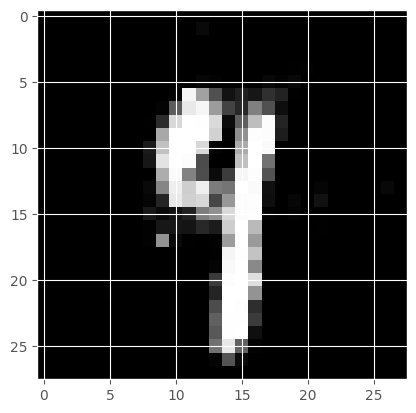

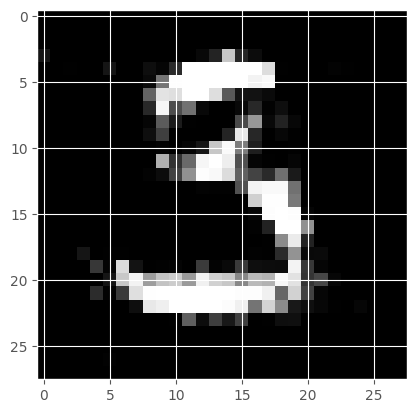

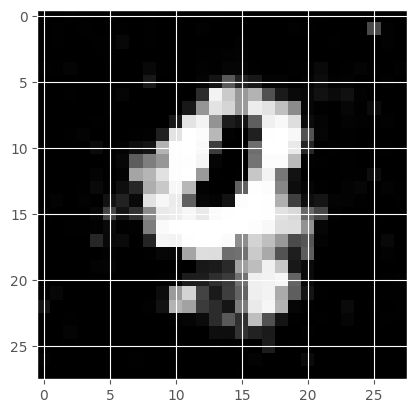

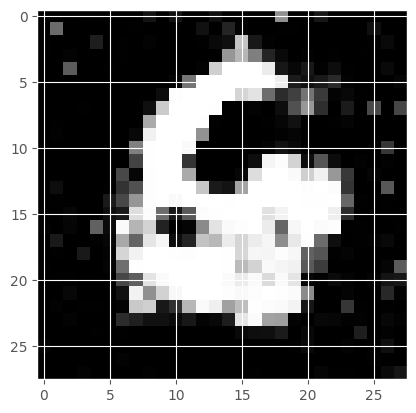

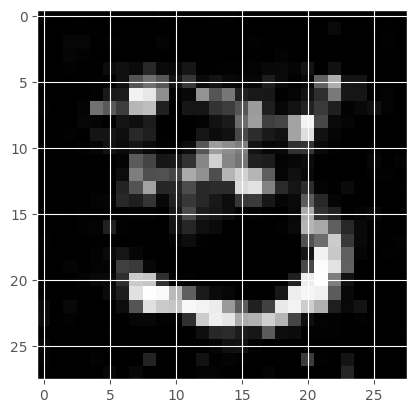

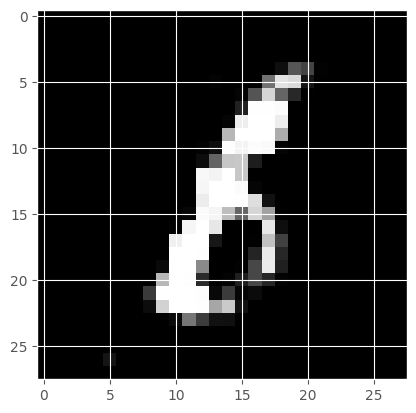

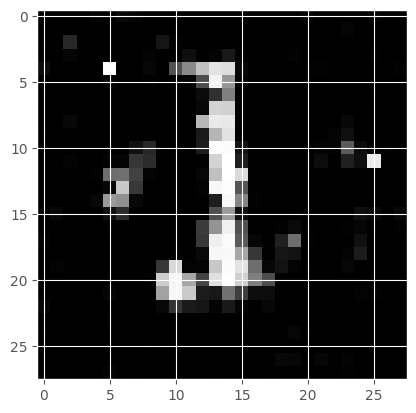

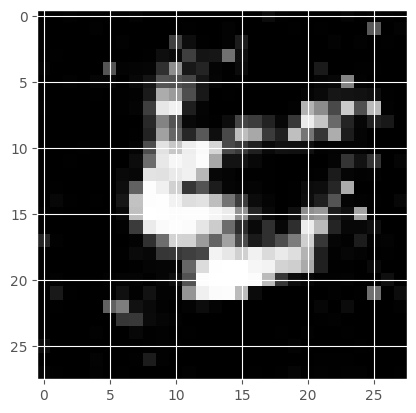

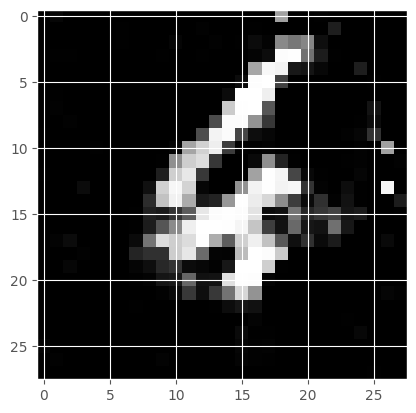

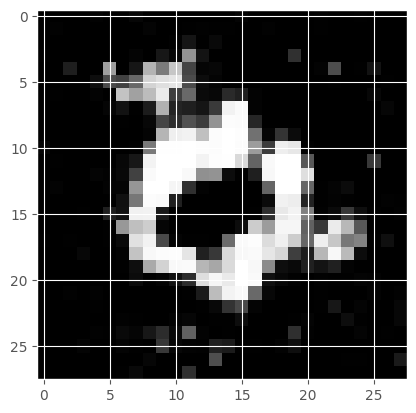

In [15]:
import numpy as np # numpy 라이브러리 import

# 생성된 이미지 출력
fake_images = generator(torch.randn(b_size, nz).to(device))
for i in range(10):
    fake_images_img = np.reshape(fake_images.data.cpu().numpy()[i], (28, 28))
    plt.imshow(fake_images_img, cmap='gray')
    plt.show()